In [12]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ideal_differential_drive import IdealDifferentialDrive

In [2]:
df = pd.read_csv("/home/sp/Desktop/doctorat/dougnnut_calib/snow_train.csv", dtype={'': int, 'ros_time': np.int64, 'joy_switch': str, 'icp_index': int, 'calib_state': str, 'estop': str, 'cmd_left_vel': float, 'meas_left_vel': float, 'cmd_right_vel': float, 'meas_right_vel': float, 'cmd_vel_x': float, 'cmd_vel_omega': float, 'icp_pos_x': float, 'icp_pos_y': float, 'icp_pos_z': float, 'icp_quat_x': float, 'icp_quat_y': float, 'icp_quat_z': float, 'icp_quat_w': float, 'voltage_left' : float, 'current_left': float, 'voltage_right': float, 'current_right': float, 'imu_x': float, 'imu_y': float, 'imu_z': float})
time = (df["ros_time"][1:] - df["ros_time"][1:].iloc[0]) / 1e9
cmd_left_vel = df["cmd_left_vel"][1:]
cmd_right_vel = df["cmd_right_vel"][1:]
model = IdealDifferentialDrive(0.3, 1.1652, 0.05)
cmd_vel_x, cmd_vel_omega = model.compute_body_vel(np.vstack([cmd_left_vel, cmd_right_vel]))

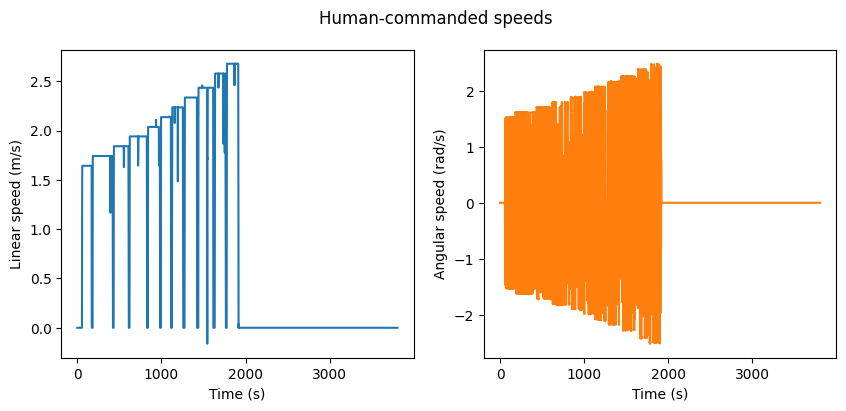

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(time, cmd_vel_x, color="C0")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Linear speed (m/s)")
ax[1].plot(time, cmd_vel_omega, color="C1")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Angular speed (rad/s)")
fig.suptitle("Human-commanded speeds")
plt.show()

In [4]:
df_out = pd.DataFrame()
df_out["cmd_vel_x"] = cmd_vel_x
df_out["cmd_vel_omega"] = cmd_vel_omega
df_out.to_csv("/home/sp/Desktop/doctorat/dougnnut_calib/human-commanded_speeds.csv")

In [5]:
train_dataset = pd.read_pickle("/home/sp/Desktop/doctorat/dougnnut_calib/acceleration_dataset.pkl")

# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = train_dataset[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = train_dataset[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = train_dataset[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = train_dataset[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = train_dataset[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = train_dataset[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)

body_vel_disturption_x_array = train_dataset[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = train_dataset[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = train_dataset[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

# compute mean body vel disturbance for each steady-state window
n_windows = len(train_dataset)

steady_state_mask = train_dataset['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

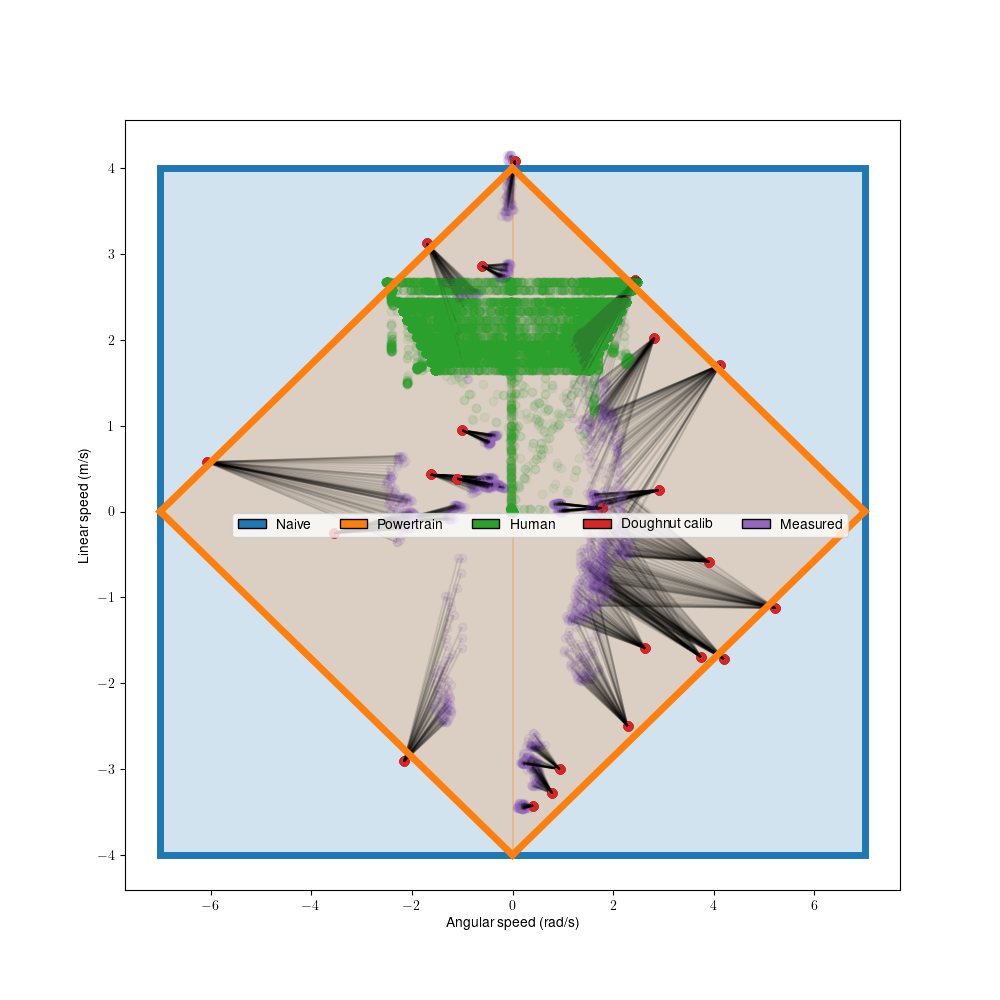

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.close('all')

fig, ax = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(10)

x_min = -7
x_max = 7
y_min = -4
y_max = 4

minimum_linear_vel_positive = 0
minimum_linear_vel_negative = 0
minimum_angular_vel_positive = 0
minimum_angular_vel_negative = 0
maximum_linear_vel_positive = 4
maximum_linear_vel_negative = -4
maximum_angular_vel_positive = 7
maximum_angular_vel_negative = -7

num_points = 100
line_width = 5
alpha = 0.2
cmd_angular_vel_linspace = np.linspace(x_min, x_max, num_points)
cmd_linear_max_vel_linspace = np.linspace(y_max, y_max, num_points)
cmd_linear_min_vel_linspace = np.linspace(y_min, y_min, num_points)

## plot initial input space
ax.plot(cmd_angular_vel_linspace, cmd_linear_min_vel_linspace, color='C0', lw=line_width, label='Uncharacterized')
ax.plot(cmd_angular_vel_linspace, cmd_linear_max_vel_linspace, color='C0', lw=line_width)
ax.vlines(x_min, y_min, y_max, color='C0', lw=line_width)
ax.vlines(x_max, y_min, y_max, color='C0', lw=line_width)
ax.fill_between(cmd_angular_vel_linspace, cmd_linear_max_vel_linspace, y2=cmd_linear_min_vel_linspace, alpha=alpha, color='C0')

char_angular_vel_linspace_negative = np.linspace(maximum_angular_vel_negative, 0, int(num_points / 2)).flatten()
char_angular_vel_linspace_positive = np.linspace(0, maximum_angular_vel_positive, int(num_points / 2)).flatten()
char_q1_vel_linspace = np.linspace(0, maximum_linear_vel_positive, int(num_points / 2)).flatten()
char_q2_vel_linspace = np.linspace(maximum_linear_vel_positive, 0, int(num_points / 2)).flatten()
char_q3_vel_linspace = np.linspace(maximum_linear_vel_negative, 0, int(num_points / 2)).flatten()
char_q4_vel_linspace = np.linspace(0, maximum_linear_vel_negative, int(num_points / 2)).flatten()

## plot characterized input space
q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C1', lw=line_width, label='Characterized')
q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C1', lw=line_width)
q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C1', lw=line_width)
q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C1', lw=line_width)
ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C1')
ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C1')

# plot icp velocities
for i in range(steady_state_idd_body_vel_yaw.shape[0]//5):
    ax.scatter(steady_state_idd_body_vel_yaw[i], steady_state_idd_body_vel_x[i], color="C3", alpha=0.5)
    ax.scatter(steady_state_icp_body_vel_yaw[i], steady_state_icp_body_vel_x[i], color="C4", alpha=0.1)
    for j in range(steady_state_idd_body_vel_yaw.shape[1]):
        ax.quiver(steady_state_idd_body_vel_yaw[i][j], steady_state_idd_body_vel_x[i][j], steady_state_icp_body_vel_yaw[i][j] - steady_state_idd_body_vel_yaw[i][j], steady_state_icp_body_vel_x[i][j] - steady_state_idd_body_vel_x[i][j], angles='xy', scale_units='xy', scale=1, width=0.03, headwidth=3, headlength=1, headaxislength=1, minlength=1, minshaft=1, units='xy', alpha=0.1)

# plot humand-commanded velocities
ax.scatter(cmd_vel_omega, cmd_vel_x, color="C2", alpha=0.03)

legend_elements = [Rectangle((0,0), width=5, height=3, facecolor="C0", label='Naive', linestyle='solid', edgecolor='k'),
                   Rectangle((0,0), width=5, height=3, facecolor="C1", label='Powertrain', linestyle='solid', edgecolor='k'),
                  Rectangle((0,0), width=5, height=3, facecolor="C2", label='Human', linestyle='solid', edgecolor='k'),
                   Rectangle((0,0), width=5, height=3, facecolor="C3", label='Doughnut calib', linestyle='solid', edgecolor='k'),
                  Rectangle((0,0), width=5, height=3, facecolor="C4", label='Measured', linestyle='solid', edgecolor='k')]
ax.set_xlabel("Angular speed (rad/s)")
ax.set_ylabel("Linear speed (m/s)")

fig.legend(handles=legend_elements, loc='center', ncol=6, bbox_to_anchor=(0.54,0.475))
fig.savefig("fig.png")
plt.show()